# Whatsapp Chat Analyzer

# Importing all the Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import re
import emoji
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

# Detecting Date and Time

In [123]:
def startsWithDateAndTime(s):
    # regex pattern for date (Works only for android)
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (AM|PM) -'
    result = re.match(pattern, s)  # search the regular expression and return the first occurrence
    if result:
        return True
    return False

# Detecting the Author

In [124]:
# Finds username of any given format.
def FindAuthor(s):
    patterns = [
        '([\w]+):',                                                     # First Name
        '([\w]+[\s]+[\w]+):',                                           # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',                                 # First Name + Middle Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+):',
        "([\w]+[\s]+[\w]+[\s]+[\w']+[\s]+[\w]+):",
        "([\w]+[\s]+[\w']+[\s]+[\w]+[\s]+[\w]+):",                      # For longer names
        '([\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+):',
        '([\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+):',
        '([+]\d{2} \d{5} \d{5}):',                                      # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',                                # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',                                 # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)                                  # ^ Starts with, | Either or
    result = re.match(pattern, s)
    if result:
        return True
    return False

# Extracting and Combining

In [125]:
def getDataPoint(line):   
    splitLine = line.split(' - ')  
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

# Parsing the entire file and handling Multi-Line Messages

In [126]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = r'C:\Users\hp\First1\Project\WhatsAppAnalyser\WhatsApp Chat with Prayatna HR dept.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
        
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        if startsWithDateAndTime(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer

In [127]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"])

In [128]:
df.head()

,Date,Time,Author,Message
0,2019-06-30,1:36 PM,Saara Vashishth Ma'am Pratyn,https://m.facebook.com/story.php?story_fbid=86...
1,2019-06-30,1:36 PM,Saara Vashishth Ma'am Pratyn,We can do something like this
2,2019-06-30,1:43 PM,Chaitanya Praytn,Great idea .!
3,2019-06-30,1:44 PM,Asmit Silhare Clg,Good idea
4,2019-06-30,1:59 PM,Kajal Praytn,Nice..


In [129]:
df.isnull().sum()

Date        0
Time        0
Author     30
Message     0
dtype: int64

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5504 entries, 0 to 5503
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     5504 non-null   datetime64[ns]
 1   Time     5504 non-null   object        
 2   Author   5474 non-null   object        
 3   Message  5504 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 172.1+ KB


In [131]:
df.describe

<bound method NDFrame.describe of            Date     Time                        Author  \
0    2019-06-30  1:36 PM  Saara Vashishth Ma'am Pratyn   
1    2019-06-30  1:36 PM  Saara Vashishth Ma'am Pratyn   
2    2019-06-30  1:43 PM              Chaitanya Praytn   
3    2019-06-30  1:44 PM             Asmit Silhare Clg   
4    2019-06-30  1:59 PM                  Kajal Praytn   
...         ...      ...                           ...   
5499 2020-11-06  2:17 PM                     Amrik Clg   
5500 2020-11-06  2:25 PM                         Ankit   
5501 2020-11-06  2:25 PM                         Ankit   
5502 2020-11-06  2:28 PM                         Ankit   
5503 2020-11-06  2:28 PM                         Ankit   

                                                Message  
0     https://m.facebook.com/story.php?story_fbid=86...  
1                         We can do something like this  
2                                         Great idea .!  
3                                    

In [132]:
df.dropna(inplace=True,axis=0)

In [133]:
df.Author.unique()

array(["Saara Vashishth Ma'am Pratyn", 'Chaitanya Praytn',
       'Asmit Silhare Clg', 'Kajal Praytn', 'Rishabh Sir Senior Clg',
       'Aayushi Praytn Junior', 'Curiosity',
       'Yashika Sharma Prytn Junior', 'Parth Shukla Praytn Clg Junior',
       'Anuj Sir Senior Prayatna', 'Mayank Sir Praytn',
       'Milan Sir Senior Praytn', 'Ridam Choudhary Praytn',
       'Devansh Verma Junior Prytn', 'Tarun Garg Junior B',
       '+91 81097 27990', 'Khushi Junior Praytn',
       'Aayushi Gurjar Praytn Junior', '+91 81035 81001',
       '+91 99777 42786', 'Vandini Bhatia Clg',
       'Aman Khandelwal Sir Praytn', '+91 77229 96776', 'Amrik Clg',
       'Ankit', 'Morya Agrawal Praytn Junior', '+91 78984 60968'],
      dtype=object)

In [134]:
df.isnull().sum()

Date       0
Time       0
Author     0
Message    0
dtype: int64

# Total Number of Messages and Media Messages

In [135]:
total= df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print('Total Messages:', total)
print('Total media messages:',media_messages)

Total Messages: 5474
Total media messages: 178


# Total Emojies

In [136]:
import regex
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [137]:
df['emoji']= df['Message'].apply(split_count)
emojies= sum(df['emoji'].str.len())
print('Total Emojies:',emojies)

Total Emojies: 3239


# Most used Emoji in Group

In [138]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
# print(emoji_dict)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,552
1,🔴,358
2,👍🏻,317
3,👍,287
4,🔥,262
...,...,...
148,🧐,1
149,😴,1
150,🤐,1
151,👎🏼,1


# Total Links in Chat

In [139]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
print('Total links:',links)

Total links: 27


# Number of Letters and Words Per message

In [140]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [141]:
messages_df.head()

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count
0,2019-06-30,1:36 PM,Saara Vashishth Ma'am Pratyn,https://m.facebook.com/story.php?story_fbid=86...,[],1,114,1
1,2019-06-30,1:36 PM,Saara Vashishth Ma'am Pratyn,We can do something like this,[],0,29,6
2,2019-06-30,1:43 PM,Chaitanya Praytn,Great idea .!,[],0,13,3
3,2019-06-30,1:44 PM,Asmit Silhare Clg,Good idea,[],0,9,2
4,2019-06-30,1:59 PM,Kajal Praytn,Nice..,[],0,6,1


In [142]:
total_letters= messages_df['Letter_Count'].sum() 
print("There are {} words in all the messages.".format(total_letters))
total_words= messages_df['Word_Count'].sum()
print("There are {} words in all the messages.".format(total_words))

There are 240173 words in all the messages.
There are 45828 words in all the messages.


# How many messages have been sent in total by each author

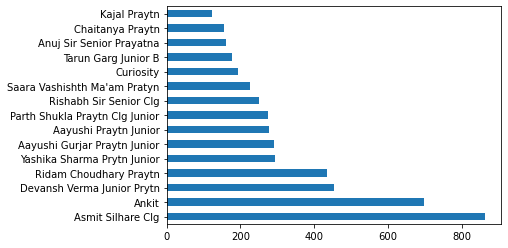

In [143]:
author_value_counts = df['Author'].value_counts() 
top_10_author_value_counts = author_value_counts.head(15) 
top_10_author_value_counts.plot.barh() 

# Who is more talkative

Text(0, 0.5, 'Authors')

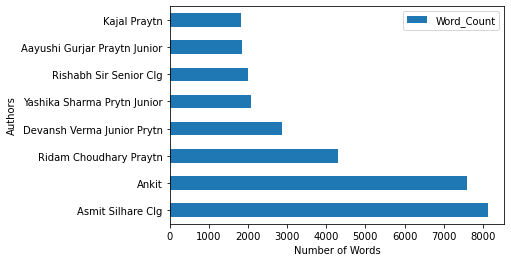

In [144]:
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(8)
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

# Most Common Number of letters in a message

Text(0, 0.5, 'Frequency')

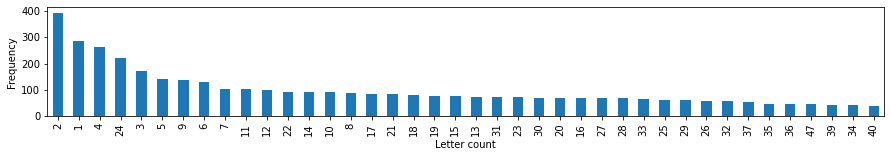

In [152]:
plt.figure(figsize=(15, 2))
letter_count_value_counts = messages_df['Letter_Count'].value_counts()
top_40_letter_count_value_counts = letter_count_value_counts.head(40)
top_40_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

# Most Common Number of words in a message

Text(0, 0.5, 'Frequency')

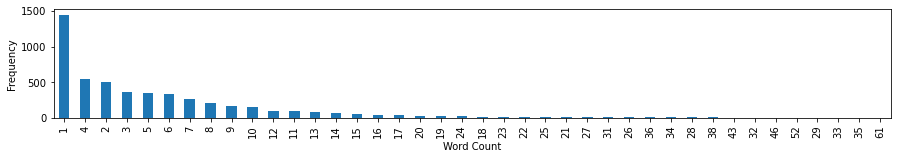

In [146]:
plt.figure(figsize=(15, 2)) 
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Most active date

Text(0, 0.5, 'Date')

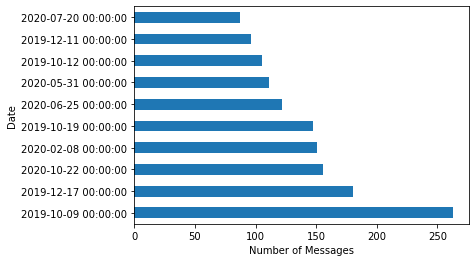

In [147]:
messages_df['Date'].value_counts().head(10).plot.barh() 
plt.xlabel('Number of Messages')
plt.ylabel('Date')

# Time when the chat is most active

Text(0, 0.5, 'Time')

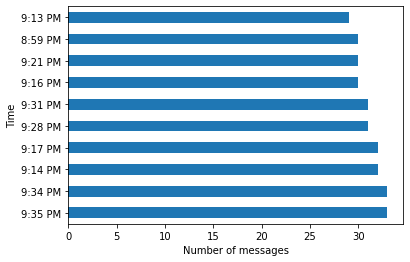

In [148]:
messages_df['Time'].value_counts().head(10).plot.barh() 
plt.xlabel('Number of messages')
plt.ylabel('Time')

# Hours in between Highest chances of responses

Text(0, 0.5, 'Hour of Day')

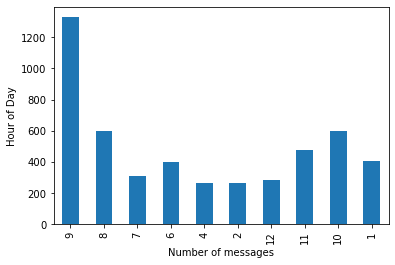

In [149]:
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0]) 
messages_df['Hour'].value_counts().head(10).sort_index(ascending=False).plot.bar() 
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

# Word Cloud to show commonly Used words

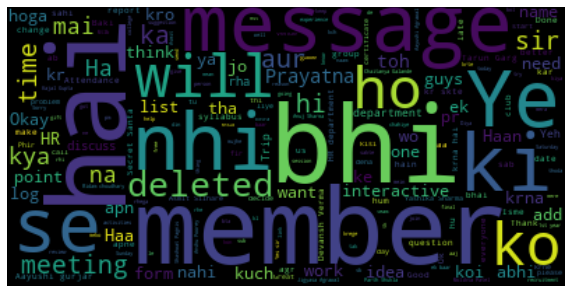

In [157]:
stopwords = set(STOPWORDS)
# stopwords.update(["le"])

wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text) # Generate a word cloud image

plt.figure( figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [151]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="Word_Count", title='Number of Messages as time moves on.')
fig.update_xaxes(nticks=20)
fig.show()